---
title: A356 Lab 2 — Linear Models 
subtitle: Fitting Lightcurves of Classically Pulsating Stars
authors:
  - name: Earl Patrick Bellinger
    orcid: 0000-0003-4456-4863
    affiliations:
      - Department of Astronomy, Yale University
license: CC-BY-4.0
---

*tags*: `linear-regression`, `penalized-regression`, `feature-selection`, `machine-learning`, `scikit-learn`, `Fourier-analysis`, `data-visualization`, `variable-stars`

## Learning Goals 

1. Create linear regression models 
2. Understand how to use a different basis (in this case, a trigonometric basis) 
3. Apply a penalty to the regression model; learn about cross-validation 
4. Learn about classically pulsating stars

## Overview

Classically pulsating stars such as Cepheids and RR Lyrae stars brighten and dim periodically, usually with a period on the order of hours or days. 

Here is an example of a phased lightcurve obtained by the OGLE project of an Anomalous Cepheid in the Galactic Bulge: 

<img src="https://ogledb.astrouw.edu.pl/~ogle/OCVS/images/02/OGLE-GAL-ACEP-002_1.jpg" alt="Anomalous Cepheid light curve" width=400 />

As a fun note, Professor Bob Zinn in this department named this class of pulsating variables. 

In this series of exercises, we will use linear regression to fit a **trigonometric model** to this phased lightcurve. This will enable you to estimate how bright the star will be at any given time in the past or future. 

Lastly, we will use penalized regression for feature selection. 

The statistical models we will be fitting serve as a compact description of the lightcurve (i.e. we extract features from the data). Use of such a model enables astronomers to compare the fitted properties of the stars with each other or with theoretical models. That in turn enables applications such as stellar classification and determination of the stellar properties, such as its mass, radius, metallicity, and age. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for unit conversions and periodogram 
from astropy import units as unt 
from astropy.timeseries import LombScargle 

# for fitting linear models 
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

# for interactive and 3D plots 
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42) # for reproducibility

In [2]:
# some code for prettier plots
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

:::{tip} Exercise 1

Let's warm up with an easier linear regression problem: one dependent variable and one independent variable. 

Here is the original 1929 data from Edwin Hubble of Cepheid-host galaxies, which made him conclude that the Universe is expanding: 
```
distances = np.array([0.21, 0.26, 0.27, 0.27, 0.45, 0.5, 0.8, 1.1, 1.4, 2.0]) # Mpc
velocities = np.array([130, 70, 185, 220, 200, 270, 300, 450, 500, 800]) # km/s
```

1. Make a plot of velocity vs. distance 
2. Obtain and plot the best fit line using ordinary linear regression (**hint**: use `sklearn`)
3. What Hubble constant does one find from these data? What did Hubble's historical measurement imply about the age of the Universe, and how does this compare to modern values? (**Hint**: km and Mpc are both distances, so $H_0$ has units of 1/time. **Extra hint**: `astropy.units` is already imported as `unt`.)
:::

In [3]:
distances = np.array([0.21, 0.26, 0.27, 0.27, 0.45, 0.5, 0.8, 1.1, 1.4, 2.0]) # Mpc
velocities = np.array([130, 70, 185, 220, 200, 270, 300, 450, 500, 800]) # km/s

In [4]:
distances = np.array([0.21, 0.26, 0.27, 0.27, 0.45, 0.5, 0.8, 1.1, 1.4, 2.0]) # Mpc
velocities = np.array([130, 70, 185, 220, 200, 270, 300, 450, 500, 800]) # km/s

from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False) # As mentioned in the canvas announcement, we want to make sure the intercept
# is set to zero, so it follows v = H0 * d and not v = H0 * d + c

reg.fit(distances.reshape(-1, 1), velocities)

print(f"Slope: {reg.coef_[0]:.2f} km/s/Mpc")
print(f"Intercept: {reg.intercept_:.2f} km/s")

y = reg.coef_[0] * distances + reg.intercept_

Slope: 400.80 km/s/Mpc
Intercept: 0.00 km/s


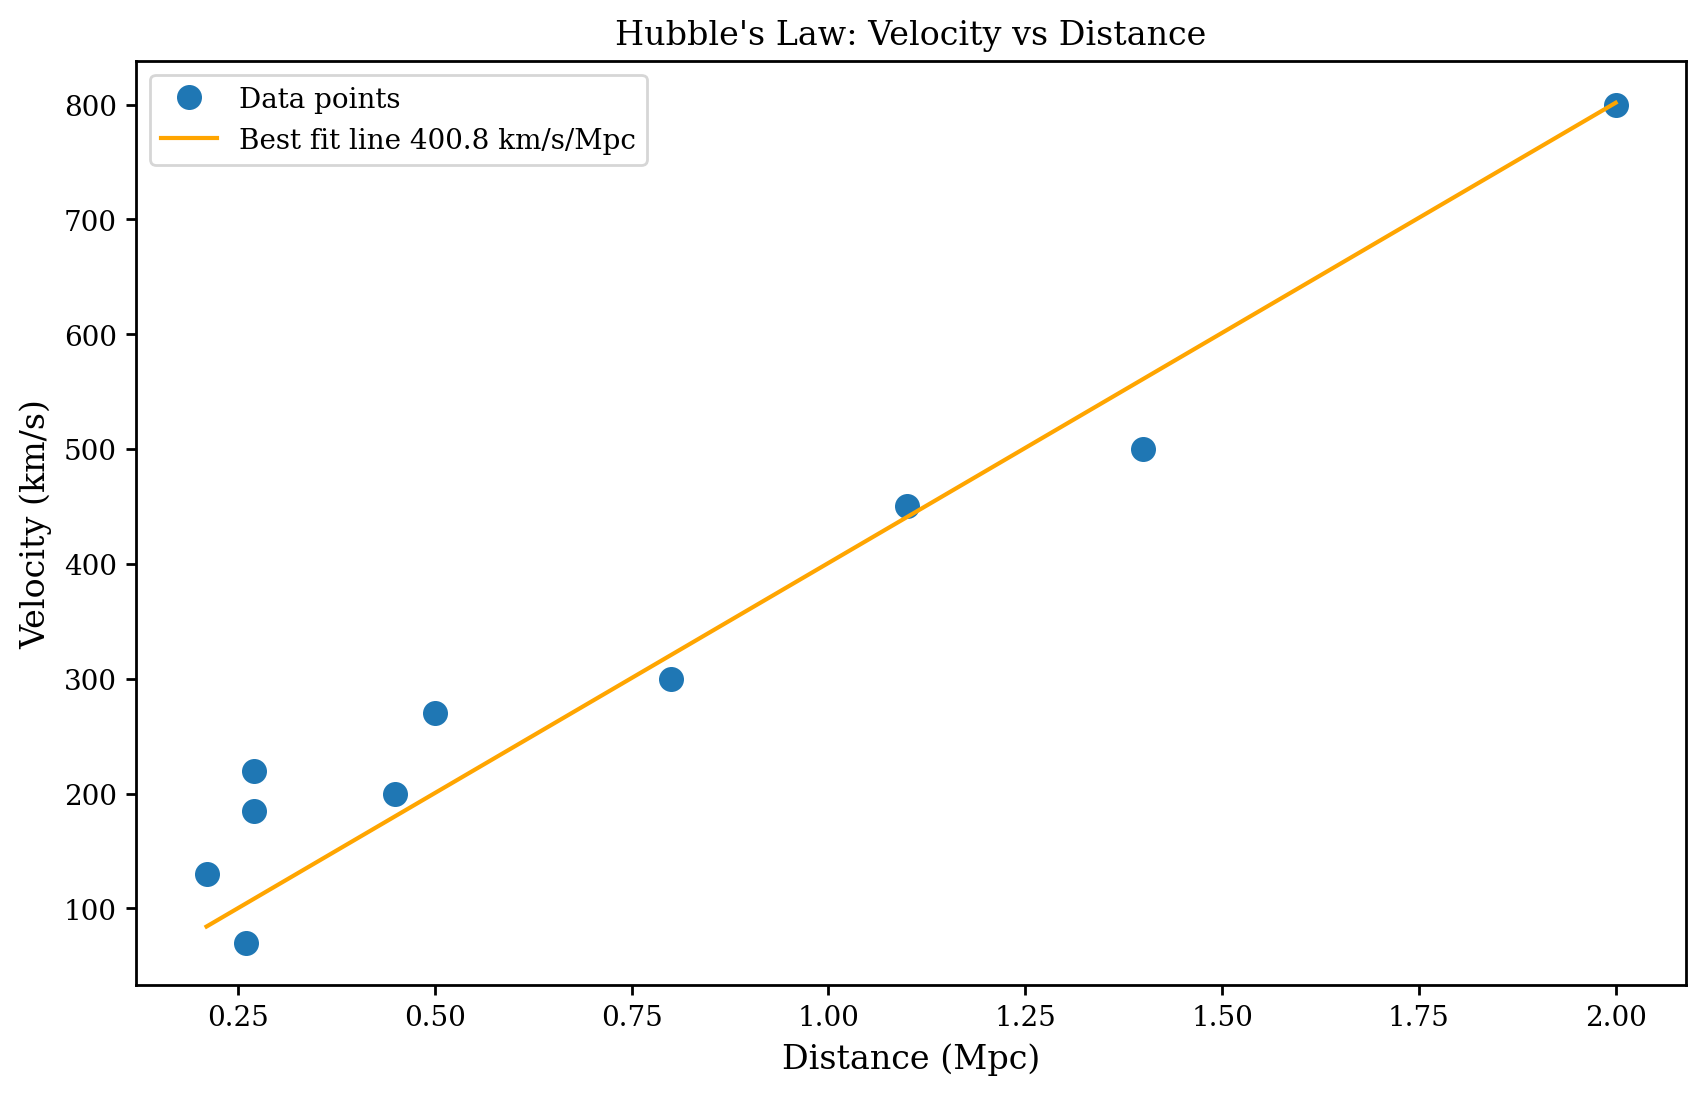

In [5]:
plt.plot(distances, velocities, 'o', markersize=8, label = 'Data points')
plt.plot(distances, y, '-', color='orange', label=f'Best fit line {reg.coef_[0]:.1f} km/s/Mpc')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)')
plt.title("Hubble's Law: Velocity vs Distance")
plt.legend()

In [6]:
## Your code here 


:::{tip} Exercise 2
Generate random data according to the linear model 
$$y = 5 + 3x_1 + 2x_2 + \epsilon$$
where $x_1$ and $x_2$ are uniform random variables, and $\epsilon$ is a normal random variable (i.e. with mean 0 and std 1). 

1. Generate 100 data points according to this model. (**Hint**: use `np.random.rand` and `np.random.normal`.)
2. Plot $y$ vs $x_1$ and $y$ vs $x_2$ in separate panels (using for example `plt.subplot(1,2,1)`, `plt.subplot(1,2,2)`). Write down: why is there so much scatter in $y$ in each panel? Is it because of the noise? (**Hint**: what happens if you set the noise to 0 or otherwise remove the noise term?) 
3. Use `sklearn` to fit one general linear model to this three-dimensional data. **Note**: The knowns are the 100 $y, x_1, x_2$ combinations. The noise $\epsilon$ that you generated is now unknown to you, as are the true model parameters. Add 3 lines to each panel of your plot using the fitted model, first corresponding to fixed values of $x_2$ and then to fixed values of $x_1$ (see the example plot below). You can achieve this for each line you want to plot by, for example, retrieving the fitted model parameters and generating points according to the fitted model where e.g. $x_1$ is set to a fixed value and $x_2$ is allowed to vary (and then vice versa). Add a third panel for the residuals (i.e. the data minus the model as a function of for example $x_1$). 
:::

In [7]:
x_1 = np.random.rand(100)
x_2 = np.random.rand(100)
epsilon = np.random.normal(0, 1, 100)

y = 5 + 3 * x_1 + 2 * x_2 + epsilon
y_NoNoise = 5 + 3 * x_1 + 2 * x_2
data = pd.DataFrame({'y': y,'y_NoNoise': y_NoNoise, 'x_1': x_1, 'x_2': x_2})
data.head()

,y,y_NoNoise,x_1,x_2
0,5.506454,6.186479,0.374540,0.031429
1,9.357217,9.124964,0.950714,0.636410
2,8.117766,7.824694,0.731994,0.314356
3,7.098765,7.813117,0.598658,0.508571
4,9.148963,7.283189,0.156019,0.907566


The reason there is so much scatter in y in each panel is because y depends on both x_1 and x_2.
When we plot y against only one of the variables, the influence of the other variable appears as scatter.
When I get rid of the noise, you can see the range of y values caused by the other x variable.


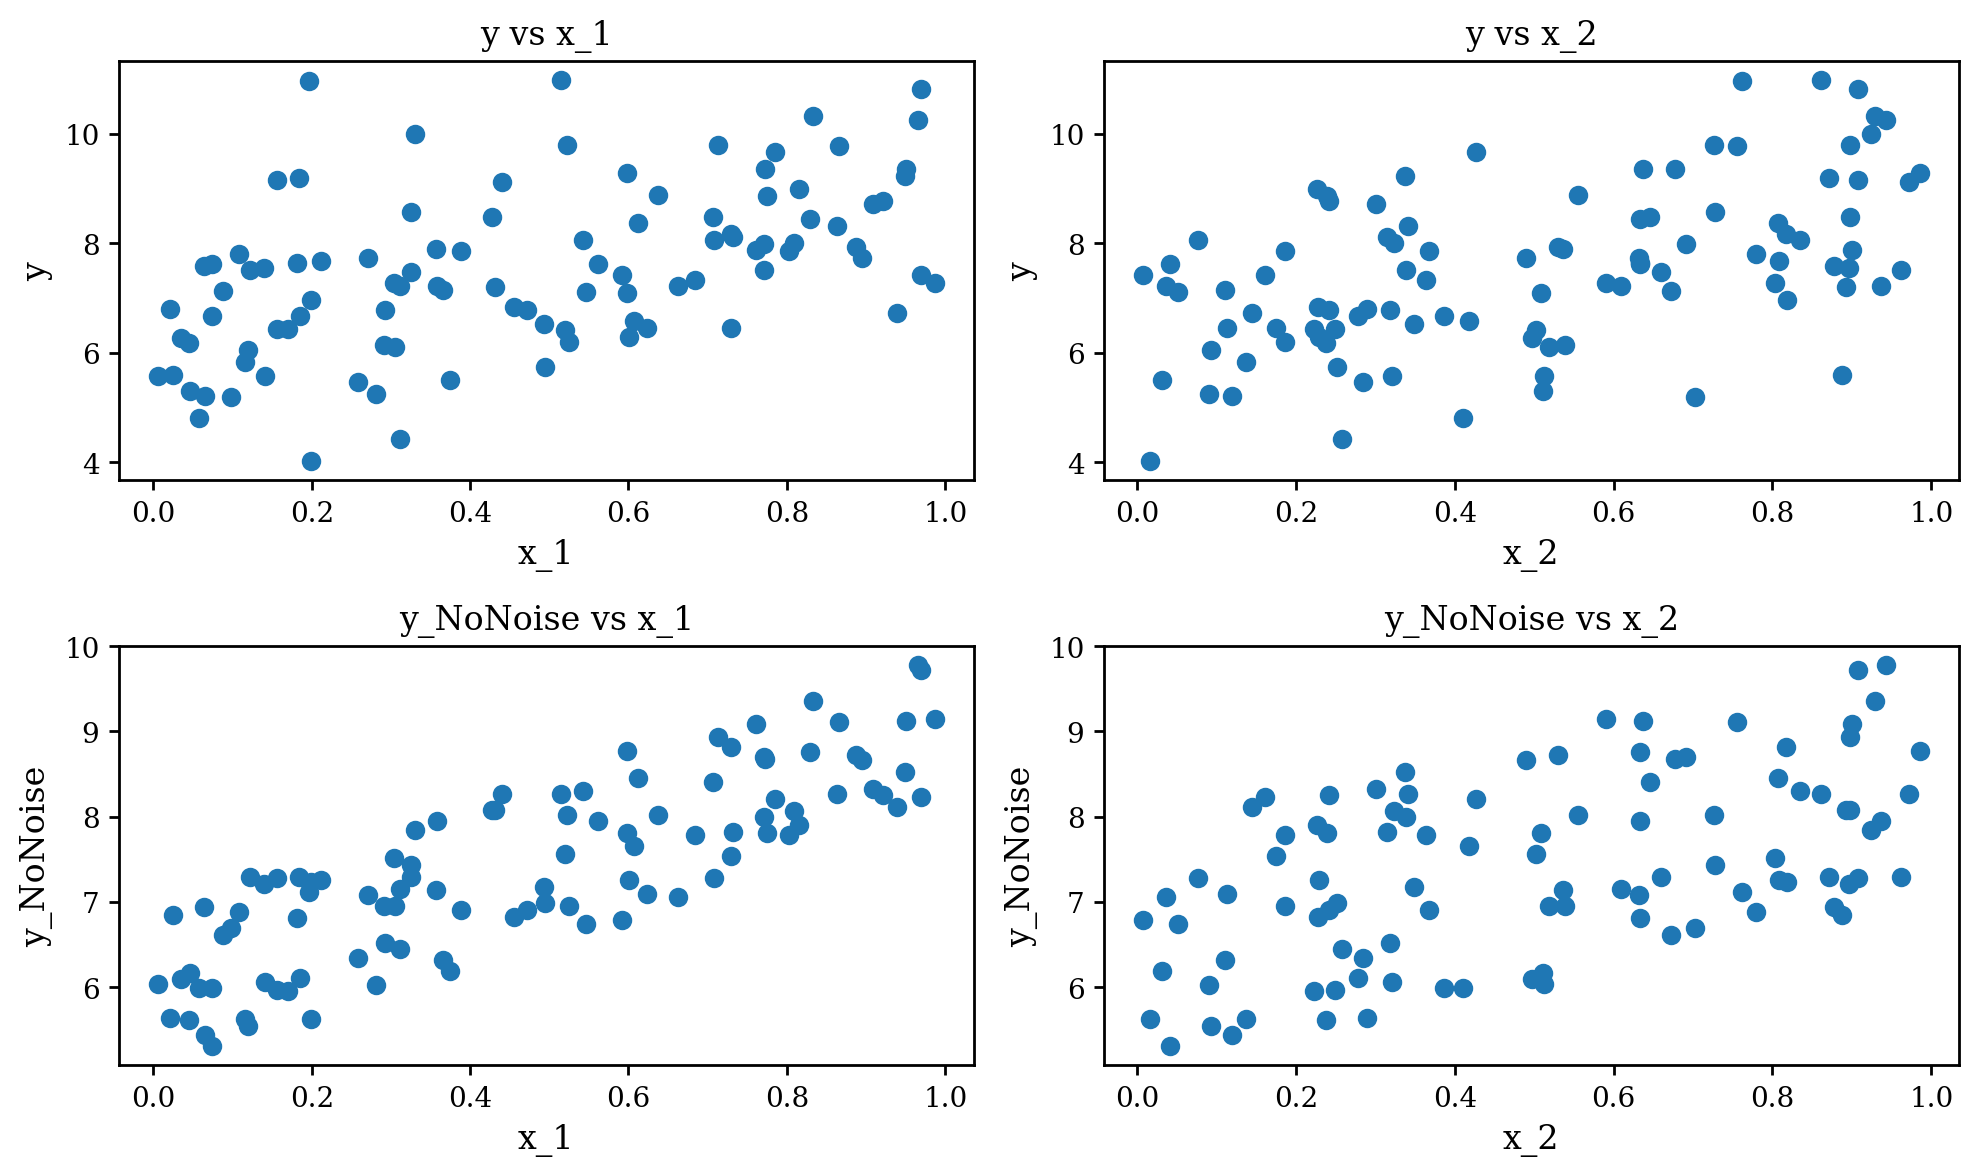

In [8]:
plt.subplot(2, 2, 1)
plt.scatter(data['x_1'], data['y'])
plt.xlabel('x_1')
plt.ylabel('y')
plt.title('y vs x_1')
plt.subplot(2, 2, 2)
plt.scatter(data['x_2'], data['y'])
plt.xlabel('x_2')
plt.ylabel('y')
plt.title('y vs x_2')

print('The reason there is so much scatter in y in each panel is because y depends on both x_1 and x_2.')
print('When we plot y against only one of the variables, the influence of the other variable appears as scatter.')
print('When I get rid of the noise, you can see the range of y values caused by the other x variable.')

plt.subplot(2, 2, 3)
plt.scatter(data['x_1'], data['y_NoNoise'])
plt.xlabel('x_1')
plt.ylabel('y_NoNoise')
plt.title('y_NoNoise vs x_1')
plt.subplot(2, 2, 4)
plt.scatter(data['x_2'], data['y_NoNoise'])
plt.xlabel('x_2')
plt.ylabel('y_NoNoise')
plt.title('y_NoNoise vs x_2')

plt.tight_layout()

In [9]:
model2 = LinearRegression()

model2.fit(data[['x_1', 'x_2']], data['y'])

intercept = model2.intercept_
coef_x1, coef_x2 = model2.coef_


In [10]:
data['x_1']

0     0.374540
1     0.950714
2     0.731994
3     0.598658
4     0.156019
        ...   
95    0.493796
96    0.522733
97    0.427541
98    0.025419
99    0.107891
Name: x_1, Length: 100, dtype: float64

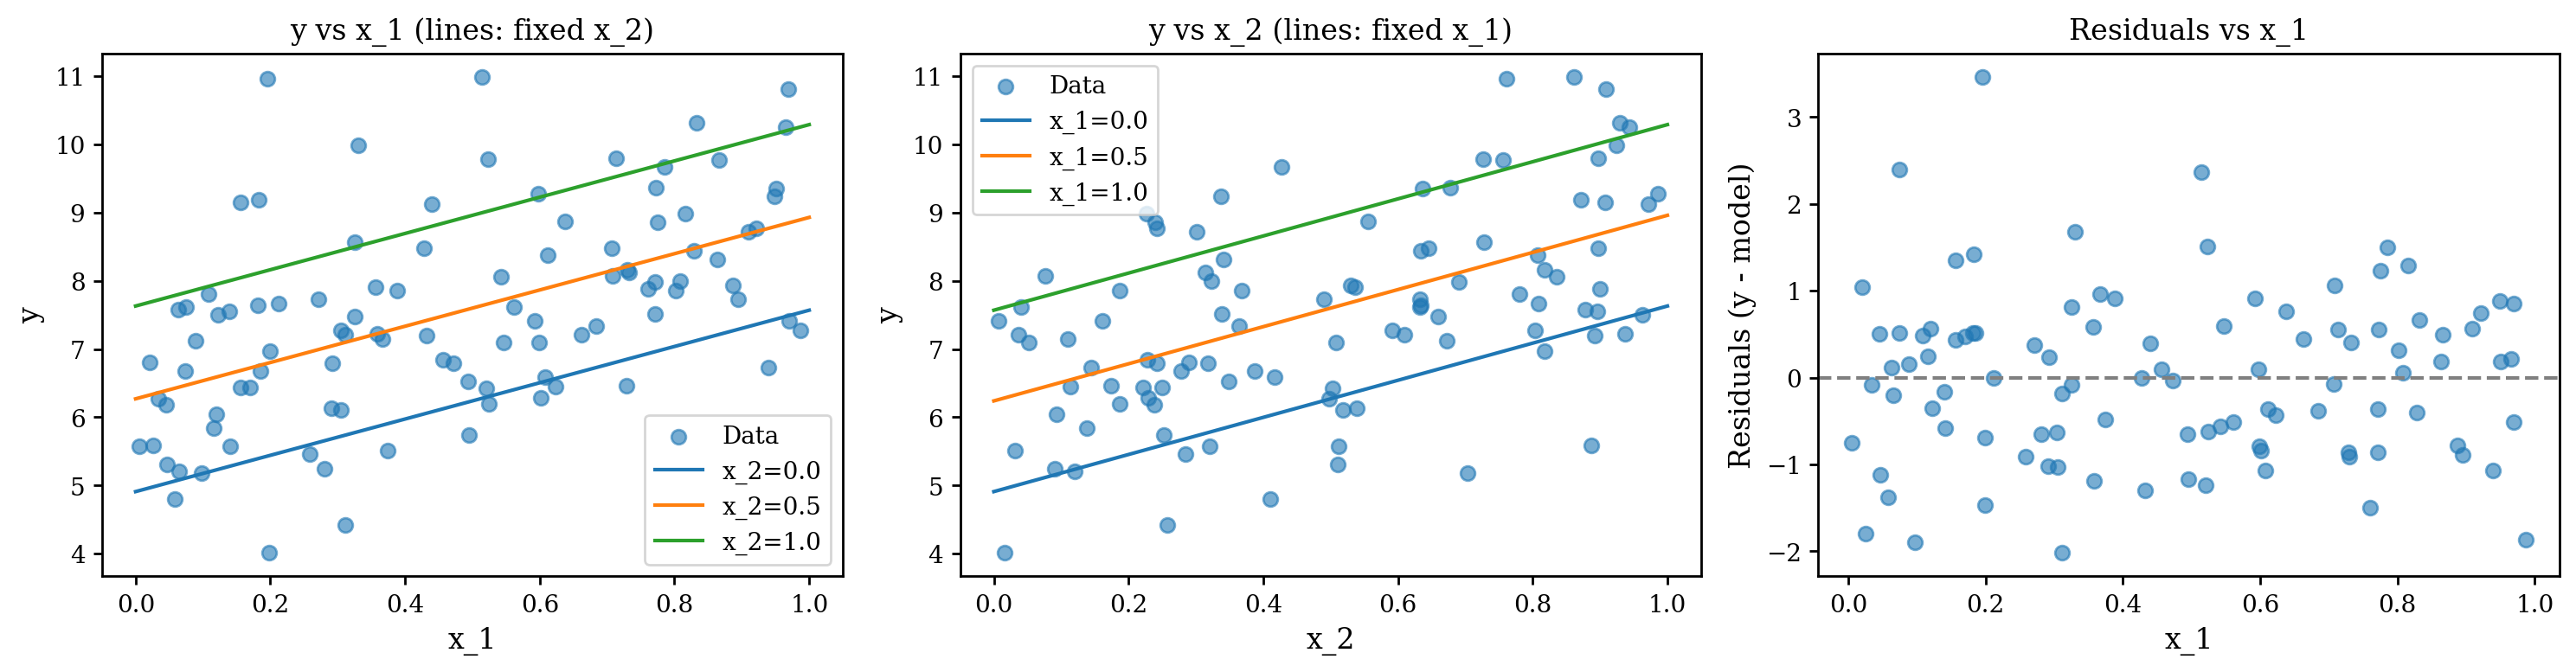

In [11]:
# Fit the linear model to y, x_1, x_2
model = LinearRegression()
model.fit(data[['x_1', 'x_2']], data['y'])

# Extract fitted parameters
intercept = model.intercept_
coef_x1, coef_x2 = model.coef_

# Prepare grids for plotting fitted lines
x1_grid = np.linspace(0, 1, 100)
x2_grid = np.linspace(0, 1, 100)


fixed_x2s = [0, 0.5, 1]
fixed_x1s = [0, 0.5, 1]

plt.figure(figsize=(15, 4))

# Panel 1: y vs x_1 with fitted lines for fixed x_2
plt.subplot(1, 3, 1)
plt.scatter(data['x_1'], data['y'], alpha=0.6, label='Data')
for fx2 in fixed_x2s:
    y_fit = intercept + coef_x1 * x1_grid + coef_x2 * fx2
    plt.plot(x1_grid, y_fit, label=f'x_2={fx2:.1f}')
plt.xlabel('x_1')
plt.ylabel('y')
plt.title('y vs x_1 (lines: fixed x_2)')
plt.legend()

# Panel 2: y vs x_2 with fitted lines for fixed x_1
plt.subplot(1, 3, 2)
plt.scatter(data['x_2'], data['y'], alpha=0.6, label='Data')
for fx1 in fixed_x1s:
    y_fit = intercept + coef_x1 * fx1 + coef_x2 * x2_grid
    plt.plot(x2_grid, y_fit, label=f'x_1={fx1:.1f}')
plt.xlabel('x_2')
plt.ylabel('y')
plt.title('y vs x_2 (lines: fixed x_1)')
plt.legend()

# Panel 3: Residuals vs x_1
y_pred = model.predict(data[['x_1', 'x_2']])
residuals = data['y'] - y_pred
plt.subplot(1, 3, 3)
plt.scatter(data['x_1'], residuals, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('x_1')
plt.ylabel('Residuals (y - model)')
plt.title('Residuals vs x_1')

plt.tight_layout()
plt.show()

:::{tip} Exercise 2 Extra Credit

Make a 3D plot of these three variables ($y$, $x_1$, $x_2$). Visualize the data as points, and include both the true and fitted model as planes. Use ipywidgets to control the orientation of the 3D plot with sliders for the elevation and azimuth. 

You will need to define a function (for example named `plot_3d`) that makes the plot, and pass this function into `interact` along with additional arguments for the orientation sliders. Your plotting function can call `fig.add_subplot(111, projection='3d')` to make a 3D plot. The following functions may be helpful: `plt.scatter`, `np.meshgrid`, `plt.plot_surface`, `plt.gca().view_init`. 

**Extra extra credit**: Add a slider for the standard deviation of the noise. You can re-scale the noise you already have, rather than generating new noise each time. 
:::

In [12]:
from ipywidgets import interact, FloatSlider, IntSlider
from mpl_toolkits.mplot3d import Axes3D


def plot_3d(elev=20, azim=30, noise_std=1.0):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    # Rescale noise
    y_rescaled = 5 + 3 * data['x_1'] + 2 * data['x_2'] + (data['y'] - data['y_NoNoise']) * (noise_std / np.std(data['y'] - data['y_NoNoise']))
    # Scatter data points
    ax.scatter(data['x_1'], data['x_2'], y_rescaled, c='b', alpha=0.5, label='Data')
    # True model plane
    x1_surf, x2_surf = np.meshgrid(np.linspace(0, 1, 30), np.linspace(0, 1, 30))
    y_true_surf = 5 + 3 * x1_surf + 2 * x2_surf
    ax.plot_surface(x1_surf, x2_surf, y_true_surf, color='green', alpha=0.3, label='True model')
    # Fitted model plane
    model = LinearRegression()
    model.fit(data[['x_1', 'x_2']], y_rescaled)
    y_fit_surf = model.intercept_ + model.coef_[0] * x1_surf + model.coef_[1] * x2_surf
    ax.plot_surface(x1_surf, x2_surf, y_fit_surf, color='orange', alpha=0.3, label='Fitted model')
    # Set view
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    ax.set_title('3D plot: Data, True Model, Fitted Model')
    # Legend workaround for surfaces
    ax.scatter([], [], [], c='green', alpha=0.3, label='True model')
    ax.scatter([], [], [], c='orange', alpha=0.3, label='Fitted model')
    ax.legend()
    plt.show()

interact(plot_3d,
         elev=IntSlider(min=0, max=90, step=5, value=20, description='Elevation'),
         azim=IntSlider(min=0, max=360, step=10, value=30, description='Azimuth'),
         noise_std=FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description='Noise Std'))

interactive(children=(IntSlider(value=20, description='Elevation', max=90, step=5), IntSlider(value=30, descri…

<function __main__.plot_3d(elev=20, azim=30, noise_std=1.0)>

:::{tip} Exercise 3

Now we will turn our focus to a pulsating star. The Optical Gravitational Lensing Experiment (OGLE) observed Cepheids in the Galaxy and Magellanic Clouds. 

We will work on the data from [OGLE-GAL-ACEP-002](https://ogledb.astrouw.edu.pl/~ogle/OCVS/getobj.php?s=OGLE-GAL-ACEP-002). 

1. Download Cepheid data from the OGLE database: `https://ogledb.astrouw.edu.pl/~ogle/OCVS/data/I/02/OGLE-GAL-ACEP-002.dat`. The columns are time (in HJD), I-band magnitude, and uncertainty.
2. Perform a bit of preprocessing: subtract 2450000 from the dates, and restrict the data to dates less than 7600 days. 
3. Plot magnitude vs. time (with appropriate errorbars). Make sure magnitudes have an inverted y-axis. 
4. Plot magnitude vs. phase (with appropriate errorbars) by phasing the times according to the pulsation period of 0.833719 days via the modulo operator: `np.mod(time/period, 2)`, where the `2` allows us to see two pulsation cycles which is visually convenient. Define this plot as a function; we will reuse it. 
:::

In [13]:
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii

data = ascii.read('data.dat', names = ['time', 'i-band_magnitude', 'uncertainty'])
data['time'] = data['time'] - 2450000
data = data[data['time']<7600]
data

time,i-band_magnitude,uncertainty
float64,float64,float64
5346.929620000068,17.036,0.011
5347.910379999783,16.546,0.008
5364.913300000131,16.893,0.008
5376.935329999775,17.065,0.01
5378.93673000019,16.757,0.008
5380.909940000158,17.04,0.01
5381.919050000142,17.03,0.01
5384.884819999803,16.885,0.01
5385.931780000217,17.035,0.008


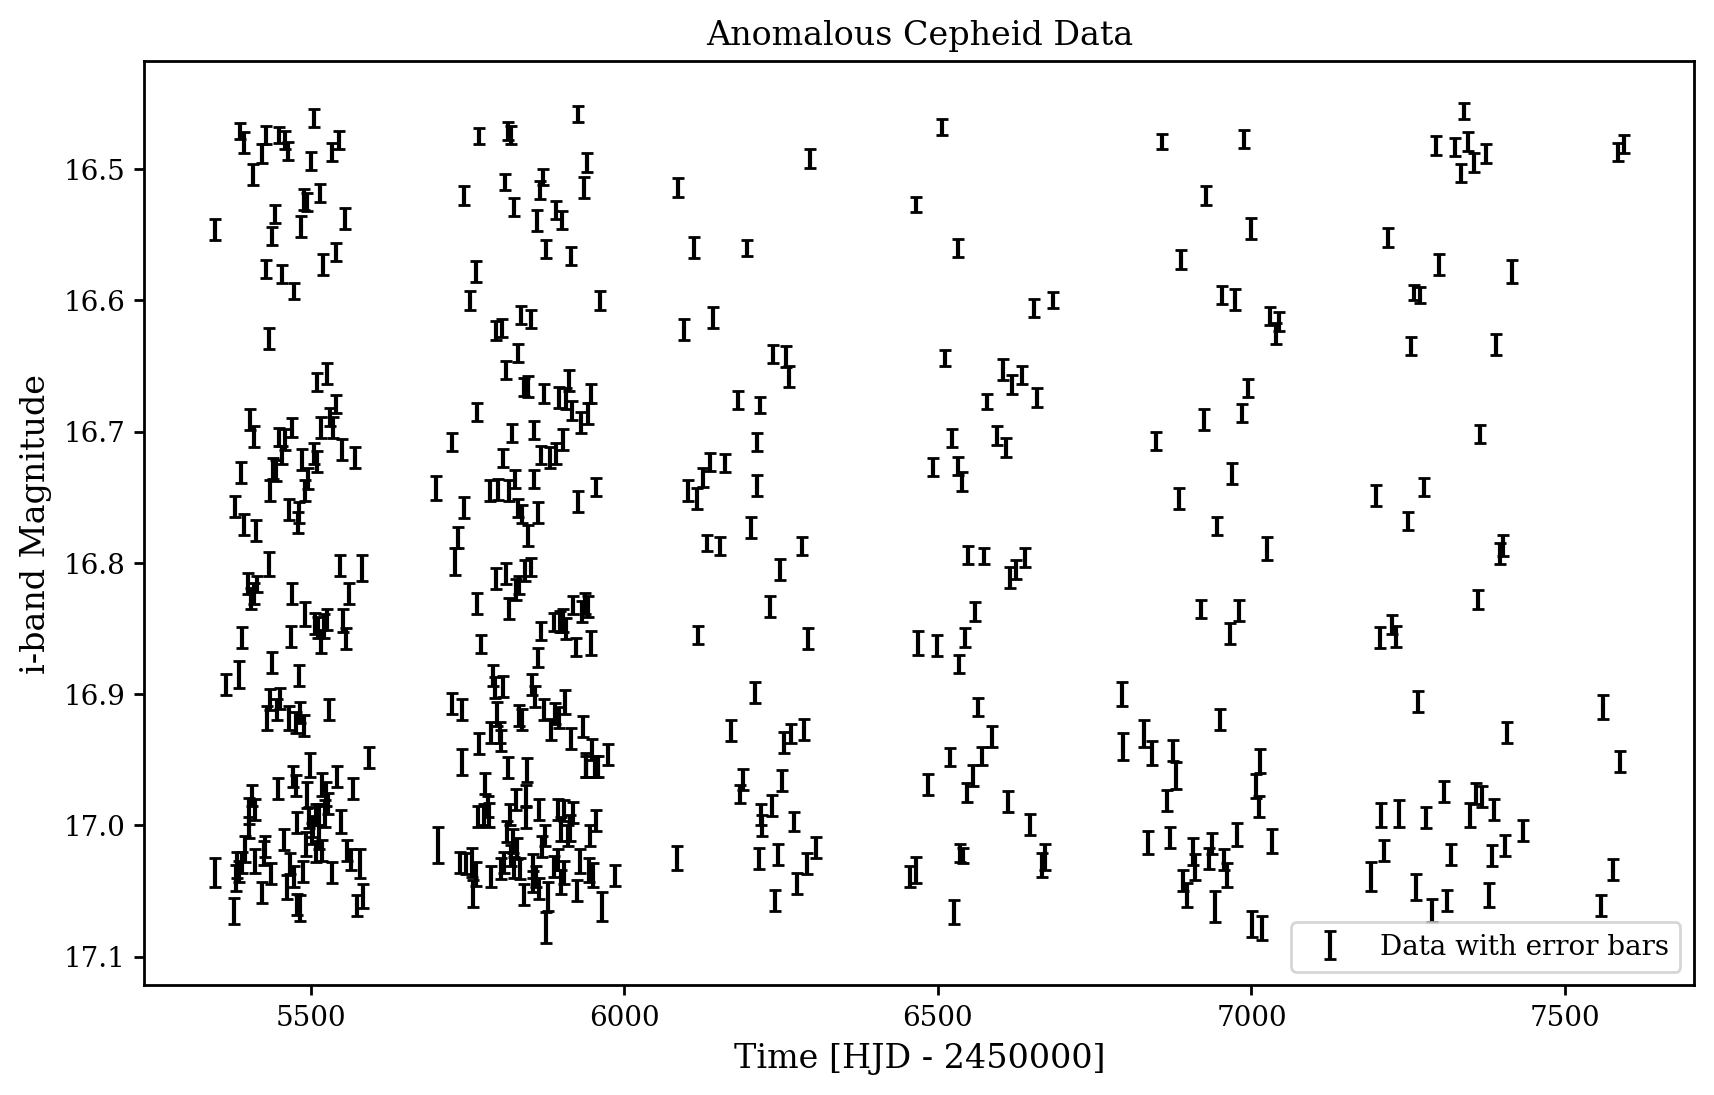

In [14]:
#plt.plot(data['time'], data['i-band_magnitude'], marker='o', linestyle='none')
plt.errorbar(data['time'], data['i-band_magnitude'], yerr=data['uncertainty'], color = 'black', fmt='none', markersize=1, capsize=2, label='Data with error bars')
plt.gca().invert_yaxis()
plt.xlabel('Time [HJD - 2450000]')
plt.ylabel('i-band Magnitude')
plt.title('Anomalous Cepheid Data')
plt.legend()

In [15]:
def phase_plot(time, period, mag, yerr):

    time = np.mod(time/period, 2)

    plt.errorbar(time, mag, yerr, color = 'black', fmt='none', linewidth = 1,capsize=1, label='Data with error bars')
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('i-band Magnitude')
    plt.title('Anomalous Cepheid Light Curve')
    plt.legend()
    plt.tight_layout()

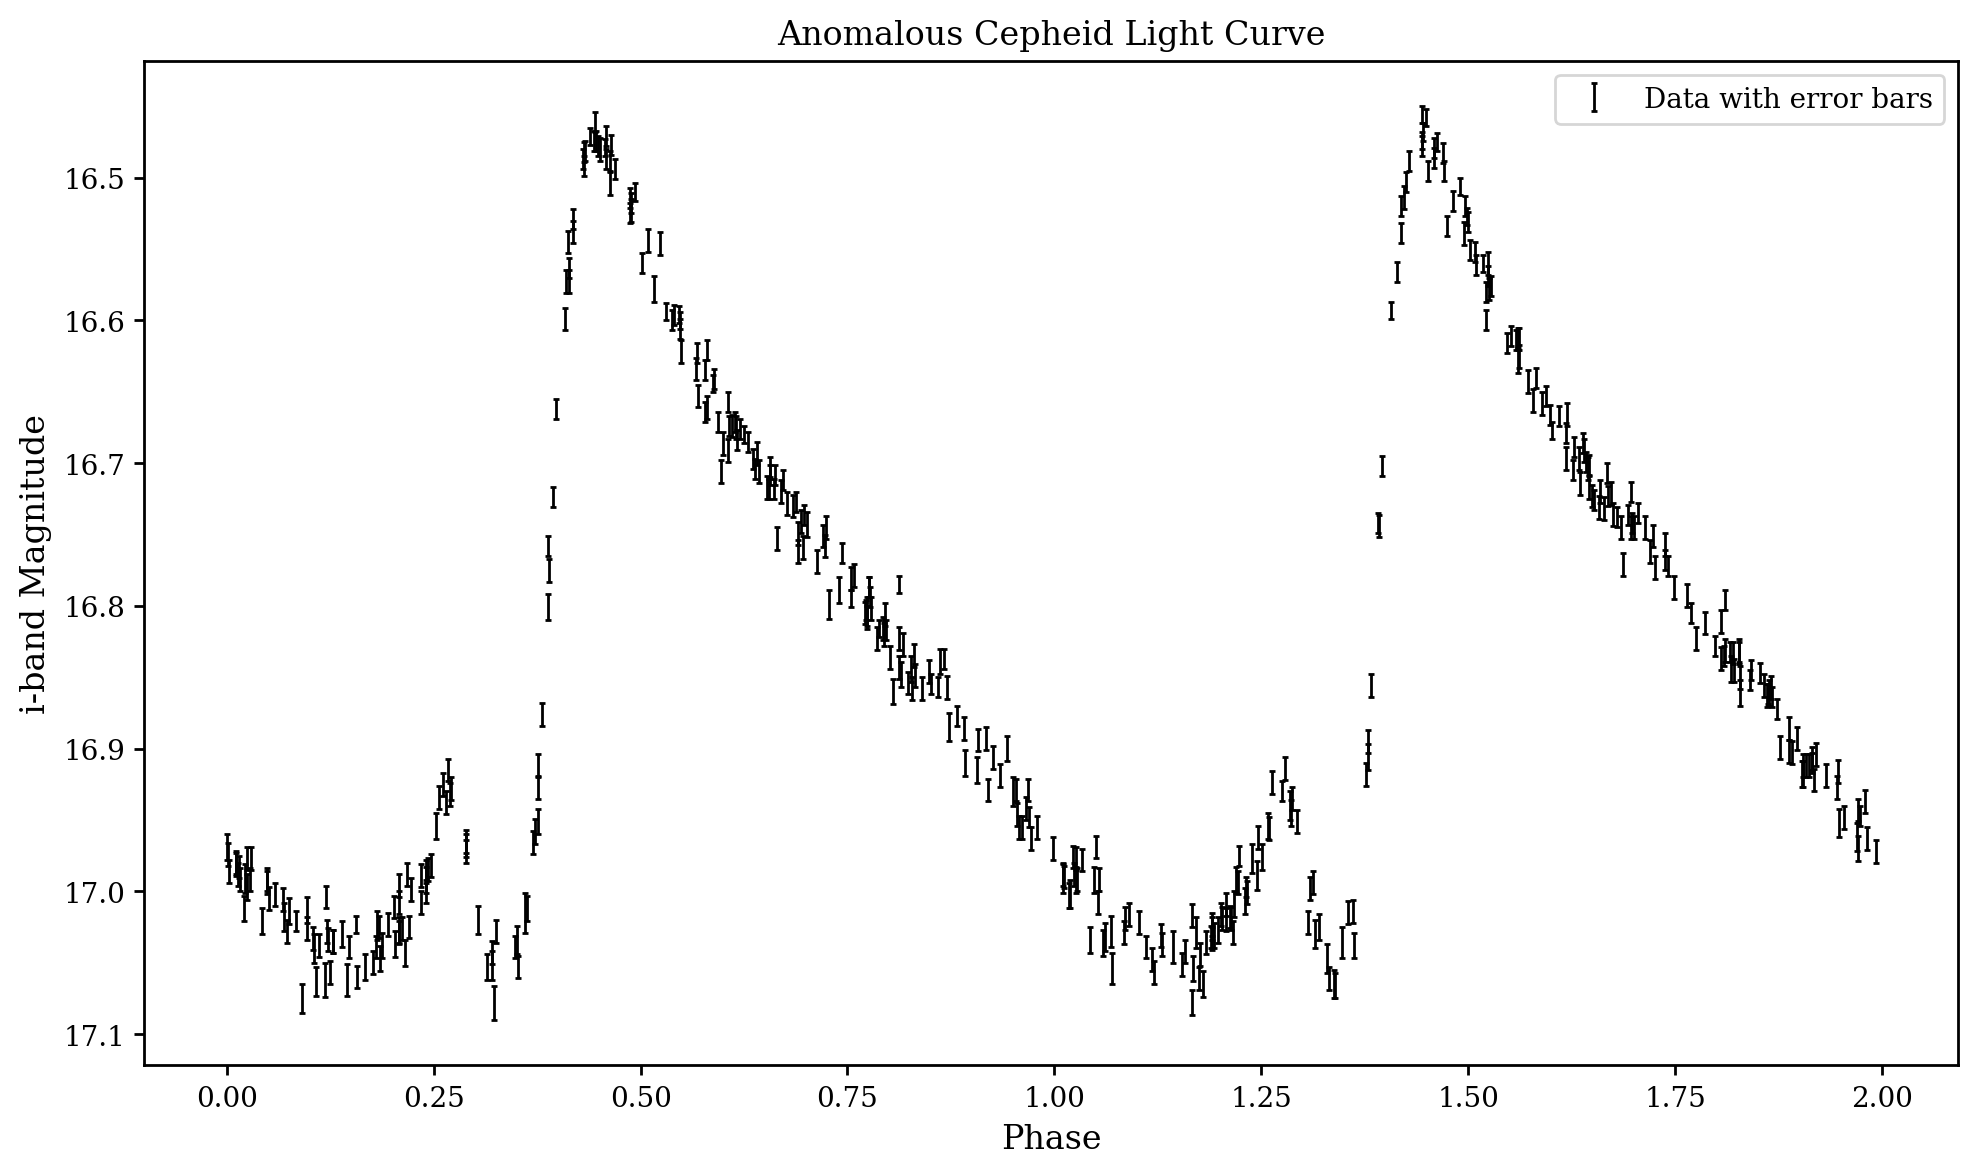

In [16]:
phase_plot(time = data['time'], period = 0.833719, mag = data['i-band_magnitude'], yerr = data['uncertainty'])

:::{tip} Exercise 4 

1. Use `LombScargle` from `astropy.timeseries` to compute a periodogram. Use a large Nyquist factor to resolve small periods. 
2. Plot power vs. frequency. Put vertical lines at the period and at its harmonics, which are located at integer divisors `period/k` for `k` up to 8. This is how the period given above was found.
:::

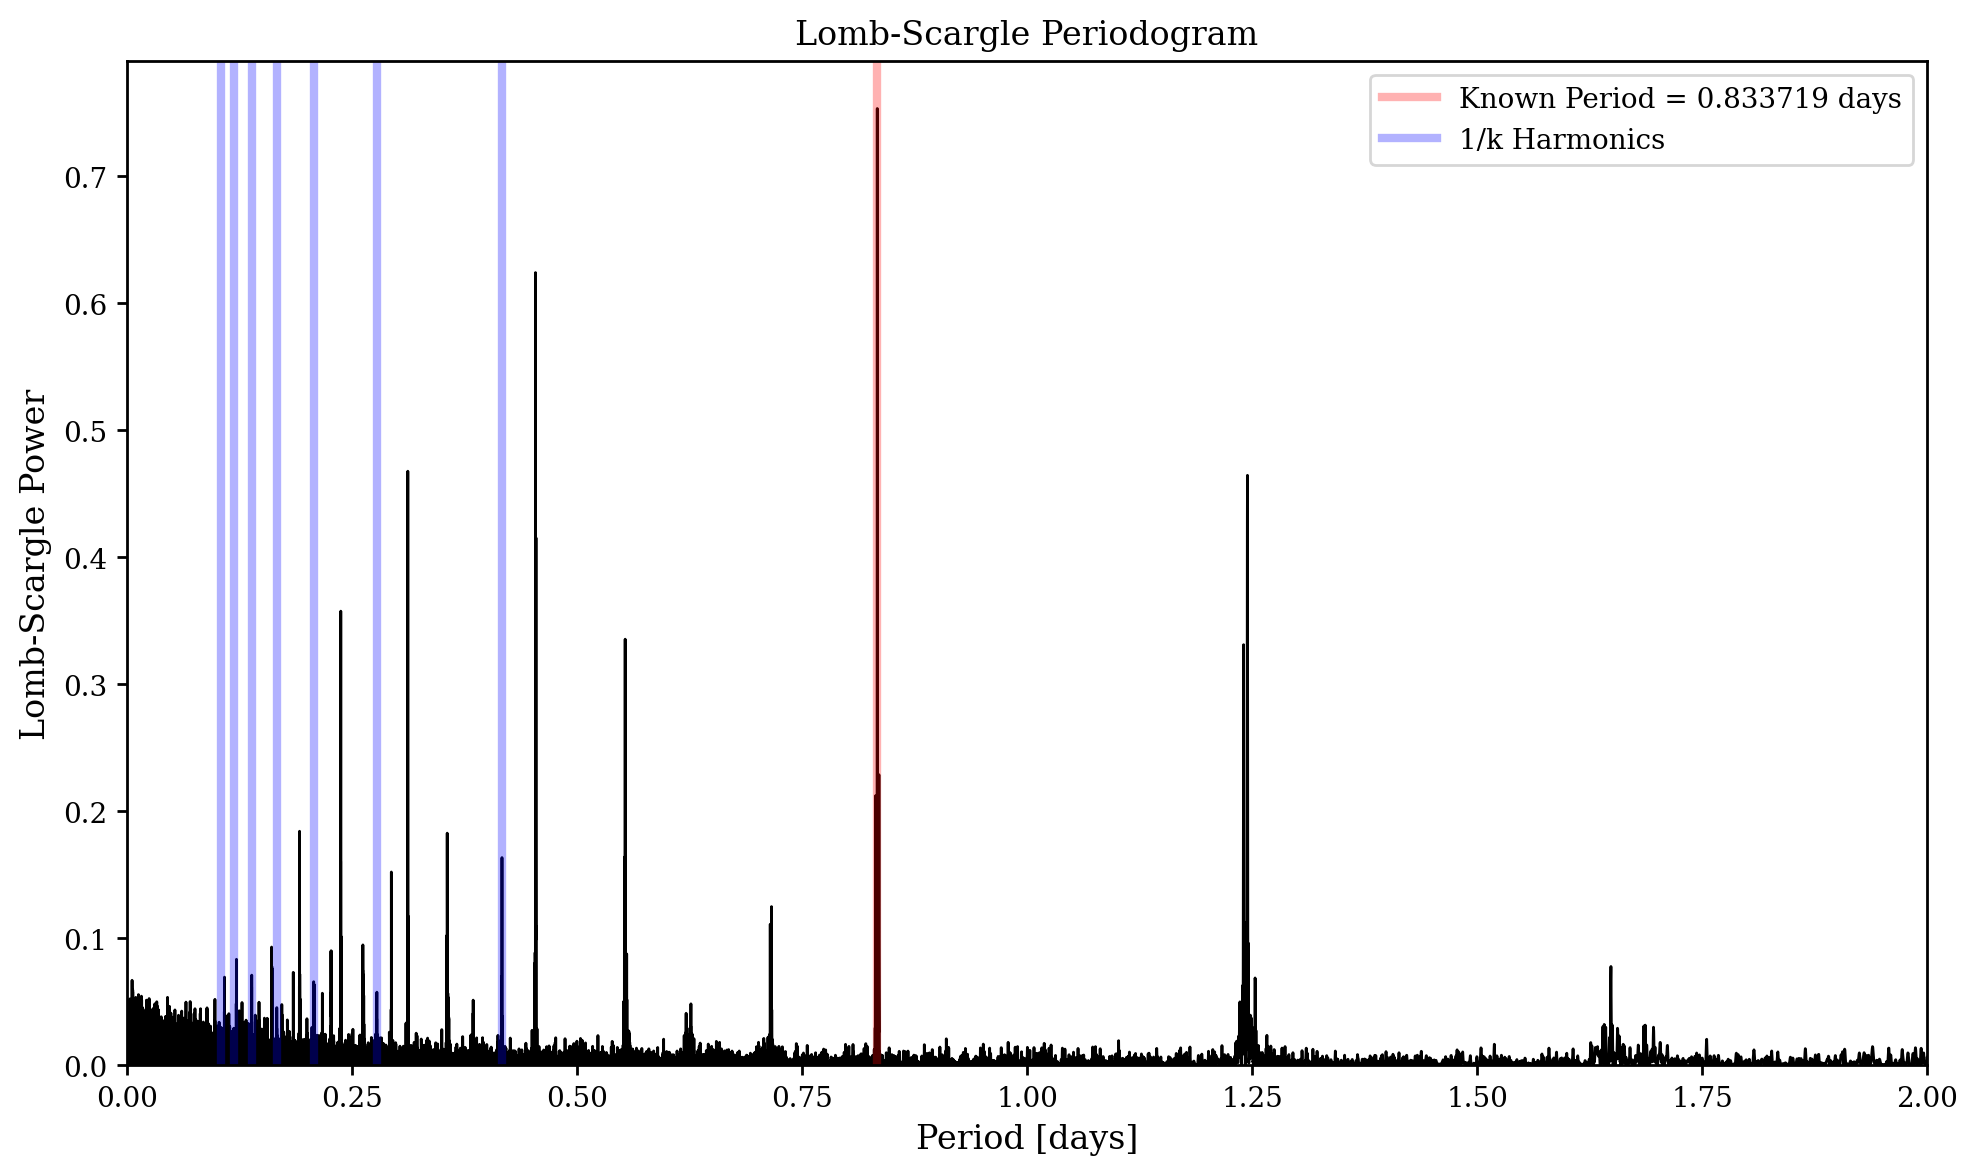

In [17]:
## Your code here 

from astropy.timeseries import LombScargle

frequency, power = LombScargle(data['time'], data['i-band_magnitude'], data['uncertainty']).autopower(nyquist_factor=3000) # I increased the nyquist_factor until I saw period values for near 0 days

plt.plot(1/frequency, power, color = 'black', linewidth=1)

plt.axvline(0.833719, color='red', linewidth = 3, alpha = 0.3, label='Known Period = 0.833719 days')
for k in range(2, 9):
    lbl = '1/k Harmonics' if k == 2 else None
    plt.axvline(0.833719 / k, color='blue', linewidth=3, alpha=0.3, label=lbl)

plt.xlabel('Period [days]')
plt.ylabel('Lomb-Scargle Power')
plt.ylim(bottom = 0)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.xlim(0,2)
plt.tight_layout()

:::{note} Trigonometric Regression

For periodic data, we can change our basis to

\begin{equation}
    y(t) = y_0 + \sum_k^{k_{\max}} S_k \sin(2\pi k t / P) + C_k \cos(2\pi k t / P)
\end{equation}

where 
- $y$ is our (observed) timeseries
- $y_0$ is a mean value (the intercept) 
- $t$ are the time points at which we have data
- $P$ is the (observed) pulsation period, assumed to be known
- $k\geq 1$ tells us how many terms are in our fit
- and we fit for the amplitudes $S,C$ (the slopes).

Note that if $\omega$ is known, then $y$ is **linear** in $\mathbf{S, C}$, and hence we can use linear regression as before. 
:::

:::{tip} Exercise 5
1. Fit a trigonometric linear regression model to the Cepheid observations. Use $k_{\max}=8$ to start with. Propagate the observational uncertainties in by setting the sample weights to $1/\sigma^2$, where $\sigma$ is the uncertainty associated with each measurement. 
2. Plot the fitted model with the data. Use an ipython widget to adjust the number of parameters $k_{\max}$ in the fit (and to update the plot).
3. Write down: What happens when you go down to small $k_{\max}$? What happens when you go to (very) large $k_{\max}$?

**Hint**: You can build the trigonometric basis (or "design matrix") in one line of python using a pair of list comprehensions with `np.column_stack`. You want every other column to be $\sin(2\pi k t / P)$ and $\cos(2\pi k t / P)$ interlaced for increasing $k$ up until $k_{\max}$. 
:::

In [18]:
def trig_design_matrix(time, period, k_max):
    return np.column_stack([
        f(2 * np.pi * k * time / period)
        for k in range(1, k_max + 1)
        for f in (np.sin, np.cos)
    ])


def fit_trig_linear(time, mag, yerr, period, k_max):
    X = trig_design_matrix(time, period, k_max)
    w = 1.0 / (np.asarray(yerr) ** 2)
    reg = LinearRegression(fit_intercept=True)
    reg.fit(X, mag, sample_weight=w)
    return reg


def predict_trig(reg, time, period, k_max):
    X = trig_design_matrix(time, period, k_max)
    return reg.predict(X)


def plot_trig_fit(time, mag, yerr, period, k_max, title_suffix=""):
    phase = np.mod(time / period, 2)
    order = np.argsort(phase)

    reg = fit_trig_linear(time, mag, yerr, period, k_max)
    y_fit = predict_trig(reg, time, period, k_max)

    plt.figure(figsize=(7, 4))
    plt.errorbar(phase[order], mag[order], yerr[order], fmt='none', color='black', linewidth=1, capsize=2, label='Data')
    plt.plot(phase[order], y_fit[order], linewidth=2, label=f'Fit (k_max={k_max})')
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('i-band Magnitude')
    plt.title(f'Anomalous Cepheid Trig Fit {title_suffix}'.strip())
    plt.legend()
    plt.tight_layout()

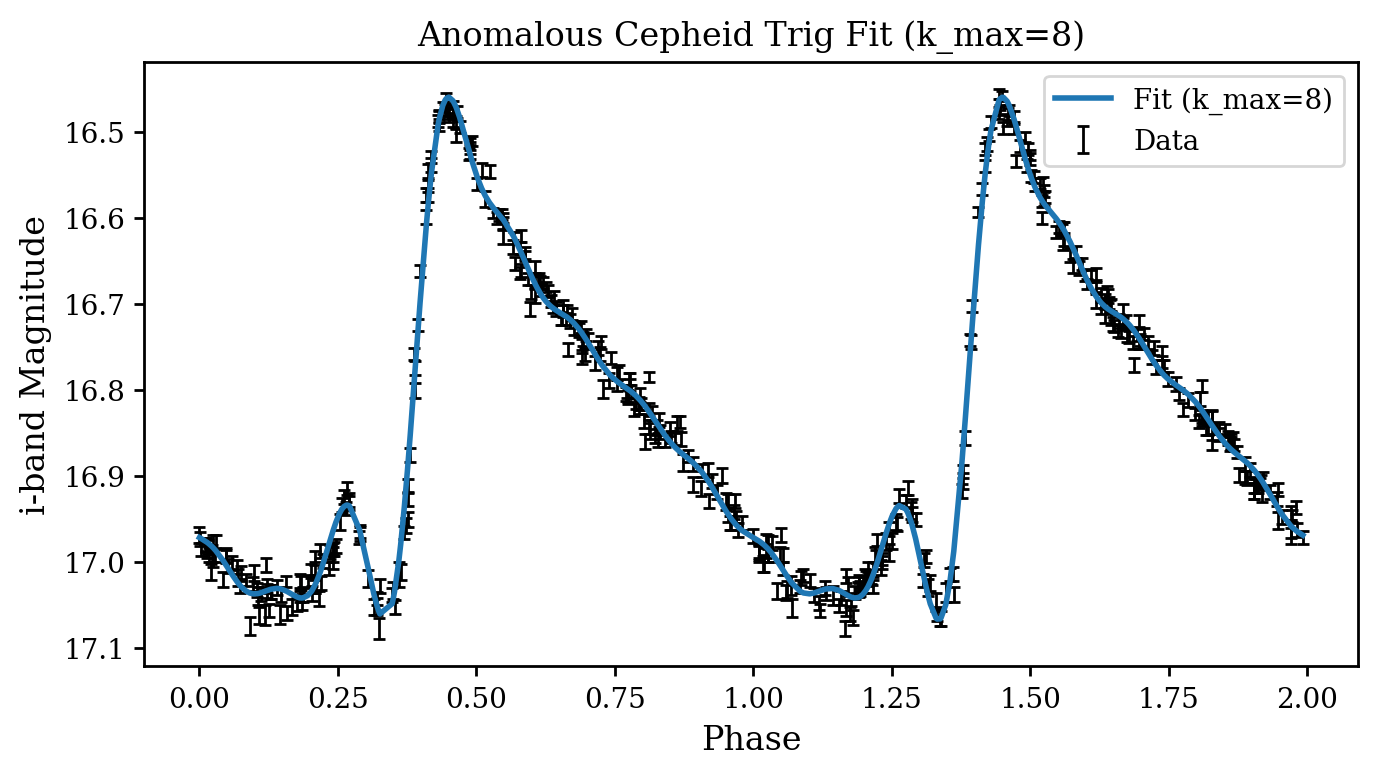

In [19]:
#k_max=8 static plot
plot_trig_fit(
    time=data['time'].data,
    mag=data['i-band_magnitude'].data,
    yerr=data['uncertainty'].data,
    period=0.833719,
    k_max=8,
    title_suffix='(k_max=8)'
)

In [20]:
## Your interactive plotting code here 

@interact(k_max=(1, 20, 1))
def _update_trig_fit(k_max=8):
    plt.clf()
    plot_trig_fit(
        time=data['time'].data,
        mag=data['i-band_magnitude'].data,
        yerr=data['uncertainty'].data,
        period=0.833719,
        k_max=k_max,
        title_suffix=f'(k_max={k_max})'
    )

interactive(children=(IntSlider(value=8, description='k_max', max=20, min=1), Output()), _dom_classes=('widget…

### Written Part
When k_max is small, it seems to underfit the data. It takes on quite a sunisoidal shape. But when k_max is increased, it starts to fit the data much better. If you increase k_max too much though, it kinda looks like it might be overfitting. It may be fitting the noise. The lines gets quite wigly in certain places. Since we weighed it like 1/sigma^2 , it would make sense that when the uncertainty it small, it may overfit near that area, as these points have more weight.

:::{note} Review of Penalized Regression: LASSO (L1 Regularization)
:class: dropdown

*a.k.a. least absolute shrinkage and selection operator*

- **Objective**: Eliminate less important features
- **Model**: Add a penalty term $\alpha \sum_{i=1}^{n} |\beta_i|$ to the loss function

Higher $\alpha$ → more penalty → more coefficients set to zero

- **Loss**: $\arg\min_{\boldsymbol\beta}||\mathbf{y} - \boldsymbol{\beta} \mathbf{X}||_2 + \alpha \sum_{i=1}^{n} |\beta_i|$
- **Solution**: No closed form! Need to search. 

Takehome message: **LASSO** completely eliminates some features.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
:::

:::{note} Review of Penalized Regression: Ridge (L2 Regularization)
:class: dropdown

*a.k.a. Tikhonov regularization*

- **Objective**: Minimize the impact of less important features

- **Model**: Add a penalty term $\alpha \sum_{i=1}^{n} \beta_i^2$ to the loss function

- **Loss**: $\arg\min_{\boldsymbol\beta}||\mathbf{y} - \boldsymbol{\beta} \mathbf{X}||_2 + \alpha \sum_{i=1}^{n} \beta_i^2$

where $\alpha$ is a regularization penalty. Higher $\alpha$ → more penalty → smaller coefficients
- **Solution**: $\boldsymbol{\hat\beta} = (\mathbf{X}^\mathrm{T}\mathbf{X} + \alpha \mathbf{I})^{-1}\mathbf{X}^\mathrm{T}\mathbf{y}$

where $\mathbf{I}$ is the identity matrix. 

Takehome message: **Ridge** reduces the magnitude of coefficients, but doesn't set them to zero.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
:::

:::{note} Review of Cross Validation
:class: dropdown
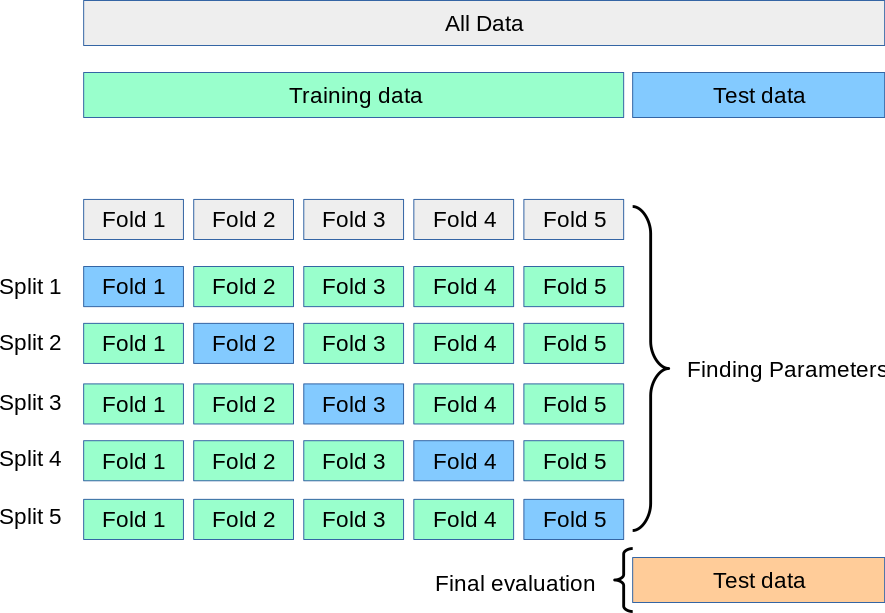

https://scikit-learn.org/stable/modules/cross_validation.html
:::

:::{tip} Exercise 6
1. Use a penalized regression model to fit the Cepheid data. Choose from L1 or L2 regularization based on what you think is more appropriate for this problem. Use a large `k_max=64`. 
2. Use an ipython widget to adjust the penalty (and to update the plot). Explore the parameter logarithmically (i.e. take `log_alpha` as input to your plotting function, and span it from -6 to 1). Write down: What happens when $\alpha$ is too small? Too large? 
3. Use cross-validation to determine the optimal penalty (and plot it). Use a smaller `k_max=12`. *Hint*: You can use e.g. `sklearn.linear_model.LassoCV`
:::

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

In [22]:
period = 0.833719


def plot_ridge_trig(time, mag, yerr, period, k_max, log_alpha=-2.0):
    alpha = 10.0**log_alpha
    X = trig_design_matrix(time, period, k_max)
    w = 1.0 / (np.asarray(yerr) ** 2)

    reg = Ridge(alpha=alpha, fit_intercept=True)
    reg.fit(X, mag, sample_weight=w)
    y_fit = reg.predict(X)

    phase = np.mod(time / period, 2.0)
    order = np.argsort(phase)

    plt.figure(figsize=(7, 4))
    plt.errorbar(phase[order], mag[order], yerr[order], fmt='none', color='black', linewidth=1, capsize=2, label='Data')
    plt.plot(phase[order], y_fit[order], linewidth=2, label=fr'Ridge fit ($k_{{max}}={k_max}$, $\alpha={alpha:.2e}$)')
    plt.gca().invert_yaxis()
    plt.xlabel('Phase')
    plt.ylabel('i-band Magnitude')
    plt.title('Trigonometric Regression with L2 Penalty')
    plt.legend()
    plt.tight_layout()

    wmse = np.average((mag - y_fit) ** 2, weights=w)
    print(f"log10(alpha) = {log_alpha:.2f}, alpha = {alpha:.3e}, weighted MSE = {wmse:.6f}")


# Interactive control: explore log10(alpha) in [-6, 1] with a large harmonic basis
@interact(log_alpha=(-15.0, 10.0, 0.1))
def _ridge_alpha_sweep(log_alpha=-2.0):
    plt.clf()
    plot_ridge_trig(
        time=data['time'].data,
        mag=data['i-band_magnitude'].data,
        yerr=data['uncertainty'].data,
        period=period,
        k_max=64,
        log_alpha=log_alpha,
    )

interactive(children=(FloatSlider(value=-2.0, description='log_alpha', max=10.0, min=-15.0), Output()), _dom_c…

### Writing Part
Right now, there isn't much of a difference between the different alpha options. However, I would expect that a high alpha would kill a lot of the data, and bring it close to being a flat line. Sure enough, when I increase the range to go up to 10, this is what I see. When alpha is super small, the penalties become super small, nearly insignificant. I'm not sure why I end up getting such a different alpha value than what is shown in the example plots, but the rest of the pset is telling me that it isn't such a bad alpha. The residuals later on look good, and visually the fit doesn't look terrible.

[CV] Best alpha: 5.790e+03


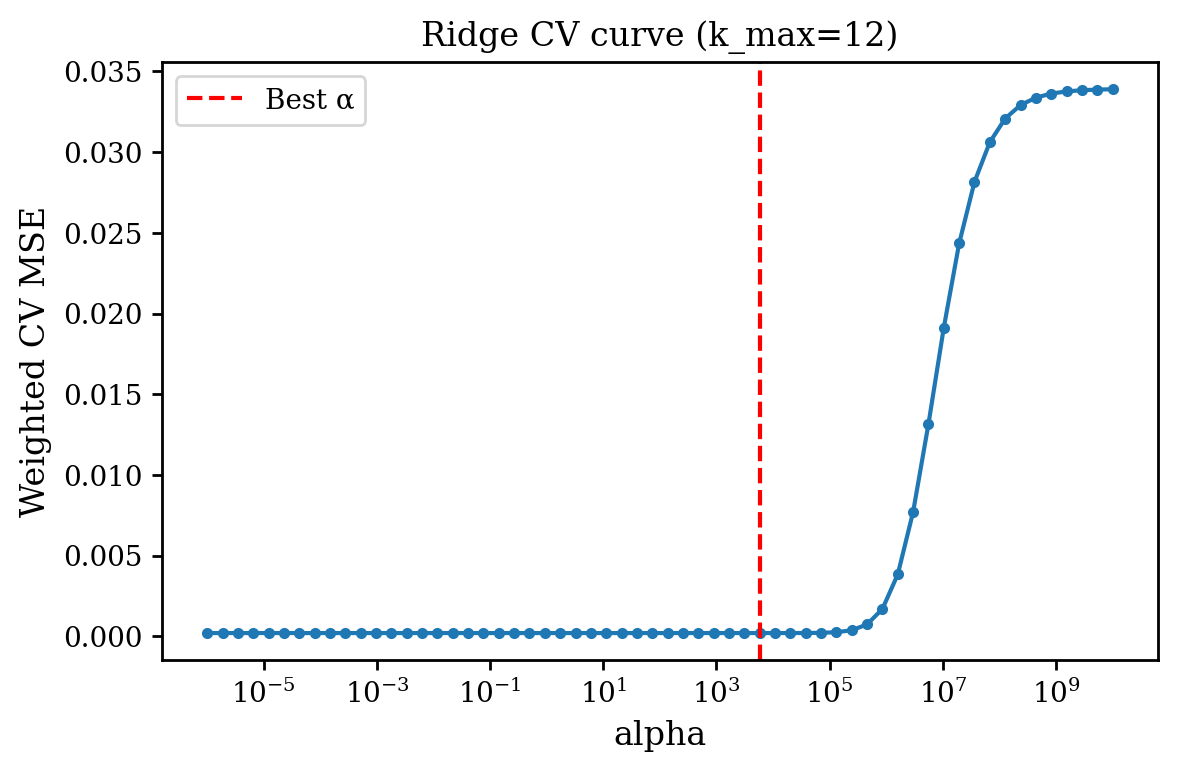

In [23]:
X12 = trig_design_matrix(data['time'].data, period, k_max=12)
Y   = data['i-band_magnitude'].data
W   = 1.0 / (data['uncertainty'].data ** 2)

alphas = np.logspace(-6, 10, 60)
cv_mse = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for a in alphas:
    fold_mse = []
    for tr, va in kf.split(X12):
        r = Ridge(alpha=a, fit_intercept=True)
        r.fit(X12[tr], Y[tr], sample_weight=W[tr])
        yhat = r.predict(X12[va])
        fold_mse.append(np.average((Y[va] - yhat) ** 2, weights=W[va]))
    cv_mse.append(np.mean(fold_mse))

best_idx = int(np.argmin(cv_mse))
best_alpha = alphas[best_idx]
print(f"[CV] Best alpha: {best_alpha:.3e}")

plt.figure(figsize=(6, 4))
plt.semilogx(alphas, cv_mse, '-o', markersize=3)
plt.axvline(best_alpha, color='r', linestyle='--', label='Best α')
plt.xlabel('alpha')
plt.ylabel('Weighted CV MSE')
plt.title('Ridge CV curve (k_max=12)')
plt.legend()
plt.tight_layout()

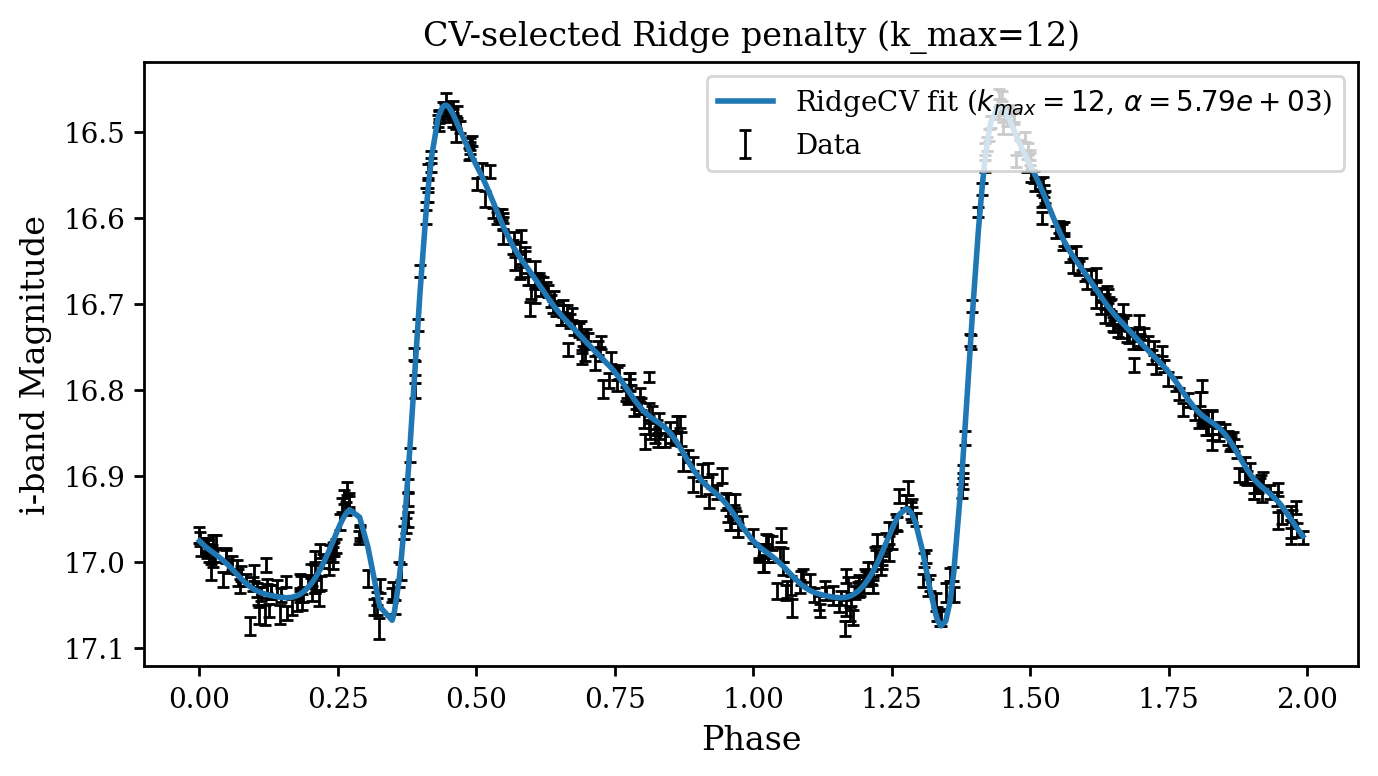

In [ ]:
# Using the CV-selected alpha for k_max=12
r_best = Ridge(alpha=best_alpha, fit_intercept=True)
r_best.fit(X12, Y, sample_weight=W)
yfit12 = r_best.predict(X12)
phase12 = np.mod(data['time'].data / period, 2.0)
ord12 = np.argsort(phase12)


# Plotting
plt.figure(figsize=(7, 4))
plt.errorbar(phase12[ord12], Y[ord12], data['uncertainty'].data[ord12], fmt='none', color='black', linewidth=1, capsize=2, label='Data')
plt.plot(phase12[ord12], yfit12[ord12], linewidth=2, label=fr'RidgeCV fit ($k_{{max}}=12$, $\alpha={best_alpha:.2e}$)')
plt.gca().invert_yaxis()
plt.xlabel('Phase')
plt.ylabel('i-band Magnitude')
plt.title('CV-selected Ridge penalty (k_max=12)')
plt.legend()
plt.tight_layout()

:::{tip} Exercise 6 Extra Credit

Revisit your plot of magnitude vs. time (not phase). Plot the cross-validated model along with the data. Zoom in on the date range `[5500, 5514]` to see the pulsations over two weeks. 

:::

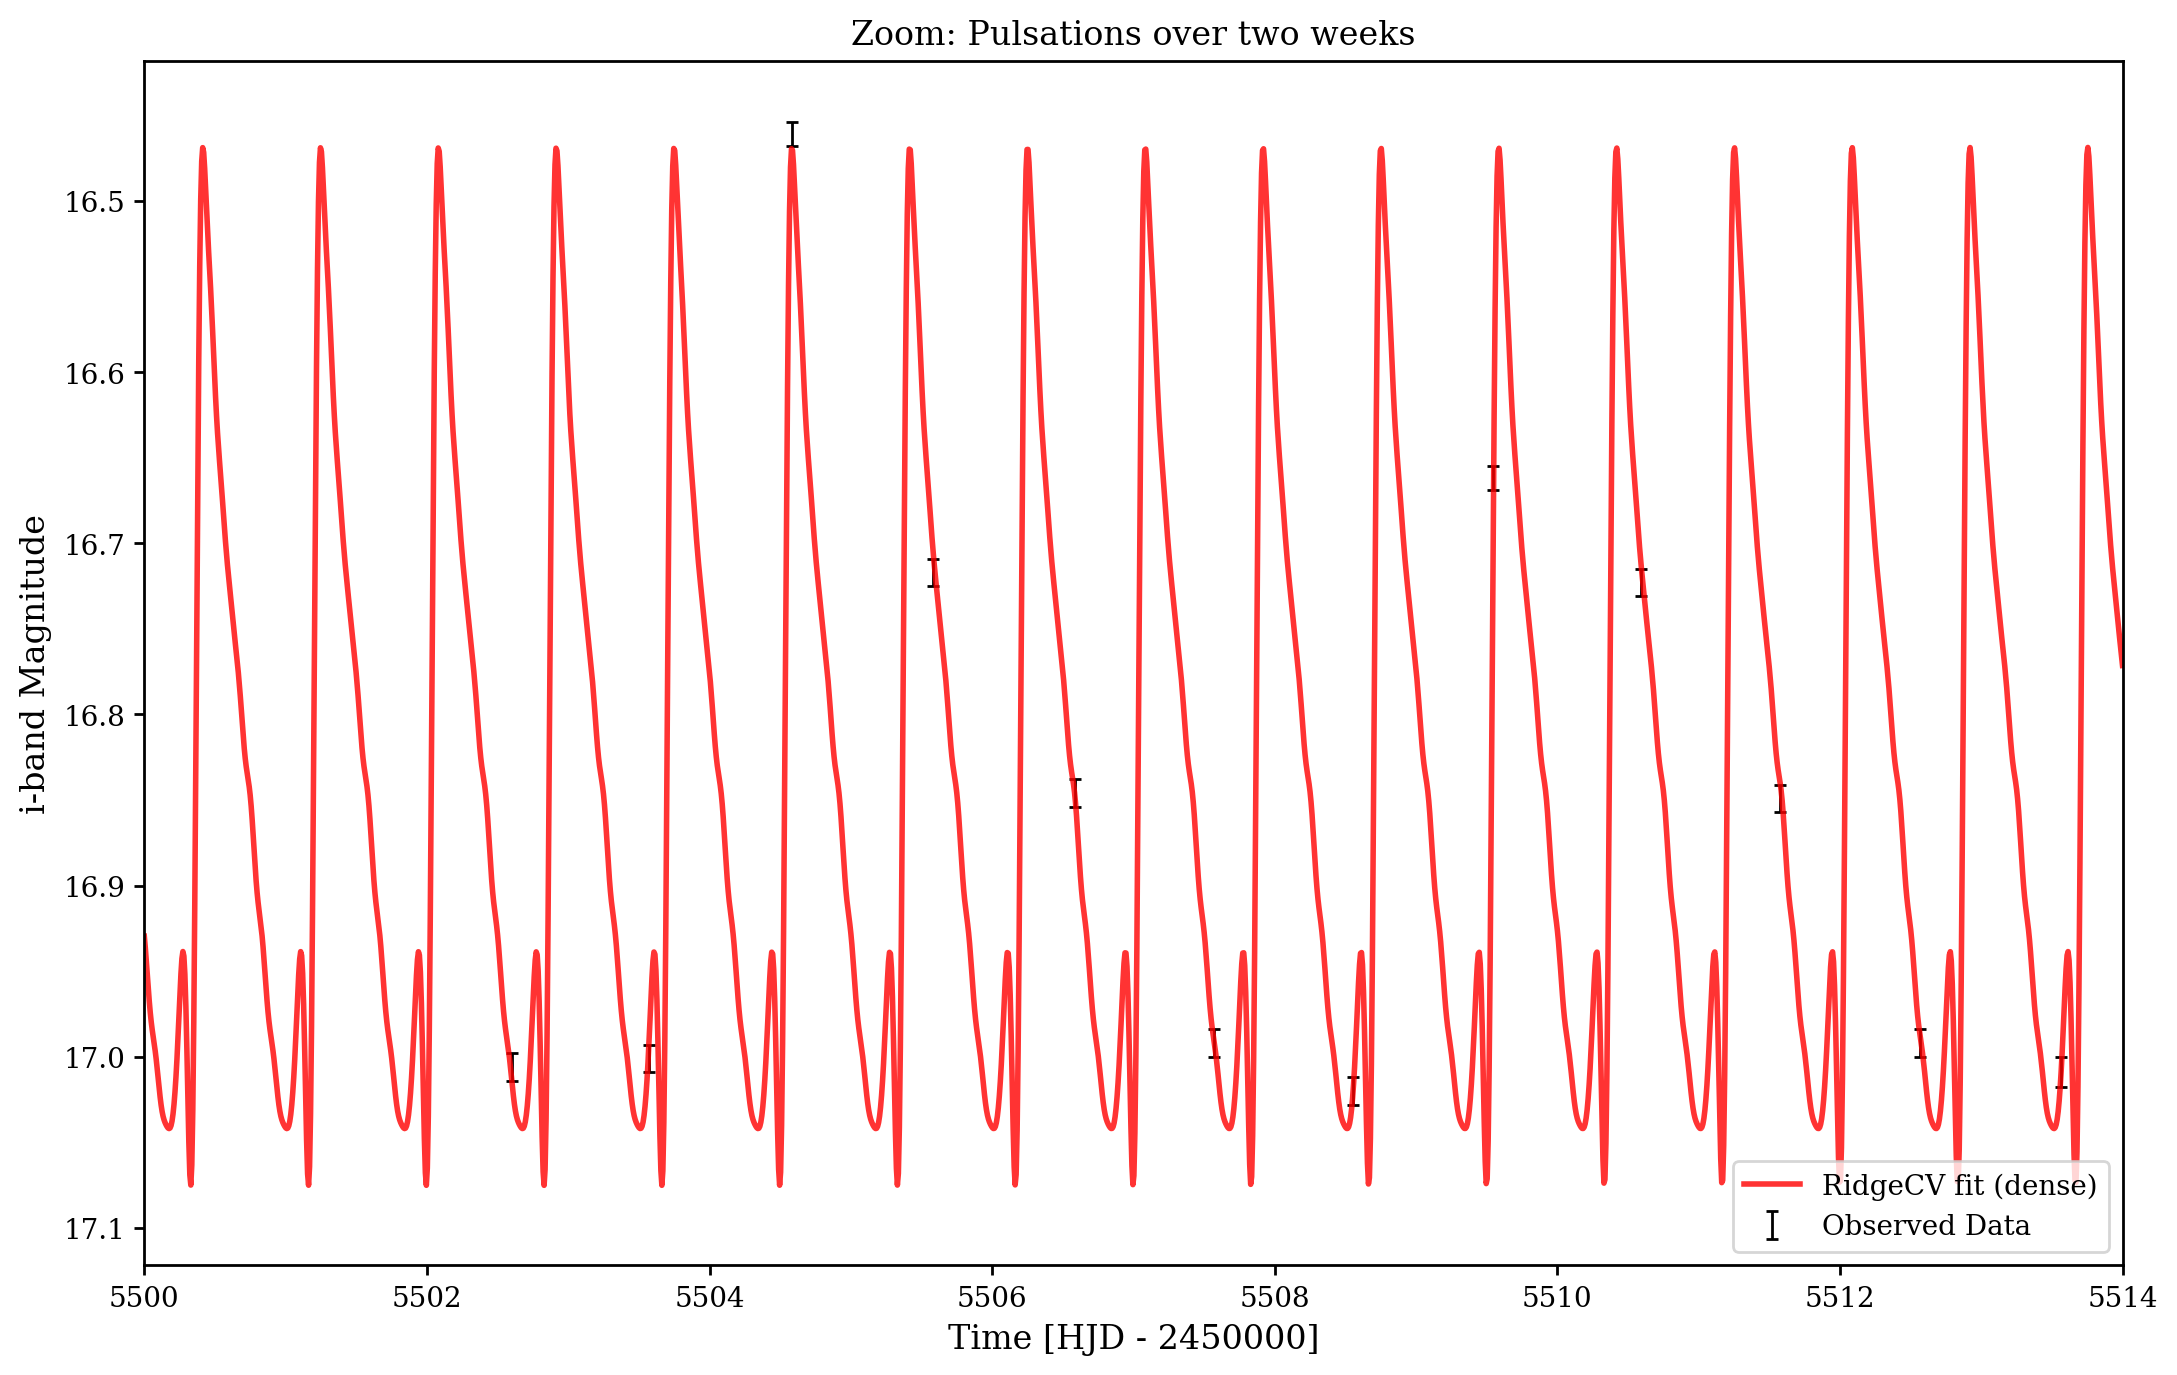

In [ ]:
# Build dense grids for smooth model rendering
_time_all = data['time'].data
_mag_all  = data['i-band_magnitude'].data
_err_all  = data['uncertainty'].data

# Full range dense grid
_time_dense_full = np.linspace(_time_all.min(), _time_all.max(), 5000)
_X_dense_full = trig_design_matrix(_time_dense_full, period, k_max=12)
_yfit_dense_full = r_best.predict(_X_dense_full)

# Zoomed dense grid over [5500, 5514]
_t0, _t1 = 5500.0, 5514.0
_time_dense_zoom = np.linspace(_t0, _t1, 2000)
_X_dense_zoom = trig_design_matrix(_time_dense_zoom, period, k_max=12)
_yfit_dense_zoom = r_best.predict(_X_dense_zoom)

fig, axes = plt.subplots(1, 1, figsize=(11, 7), sharey=True)

axes.errorbar(_time_all, _mag_all, yerr=_err_all, fmt='none', color='black', linewidth=1, capsize=2, label='Observed Data')
axes.plot(_time_dense_zoom, _yfit_dense_zoom, color='red', linewidth=2, alpha=0.8, label='RidgeCV fit (dense)')
axes.invert_yaxis()
axes.set_xlabel('Time [HJD - 2450000]')
axes.set_ylabel('i-band Magnitude')
axes.set_title('Zoom: Pulsations over two weeks')
axes.set_xlim(_t0, _t1)
axes.legend()

plt.tight_layout()

:::{tip} Exercise 7

Subtract the fitted model from the data, and plot the periodogram of the residuals. Use the same axis ranges as before. Did we fit out all the important signals? 
:::

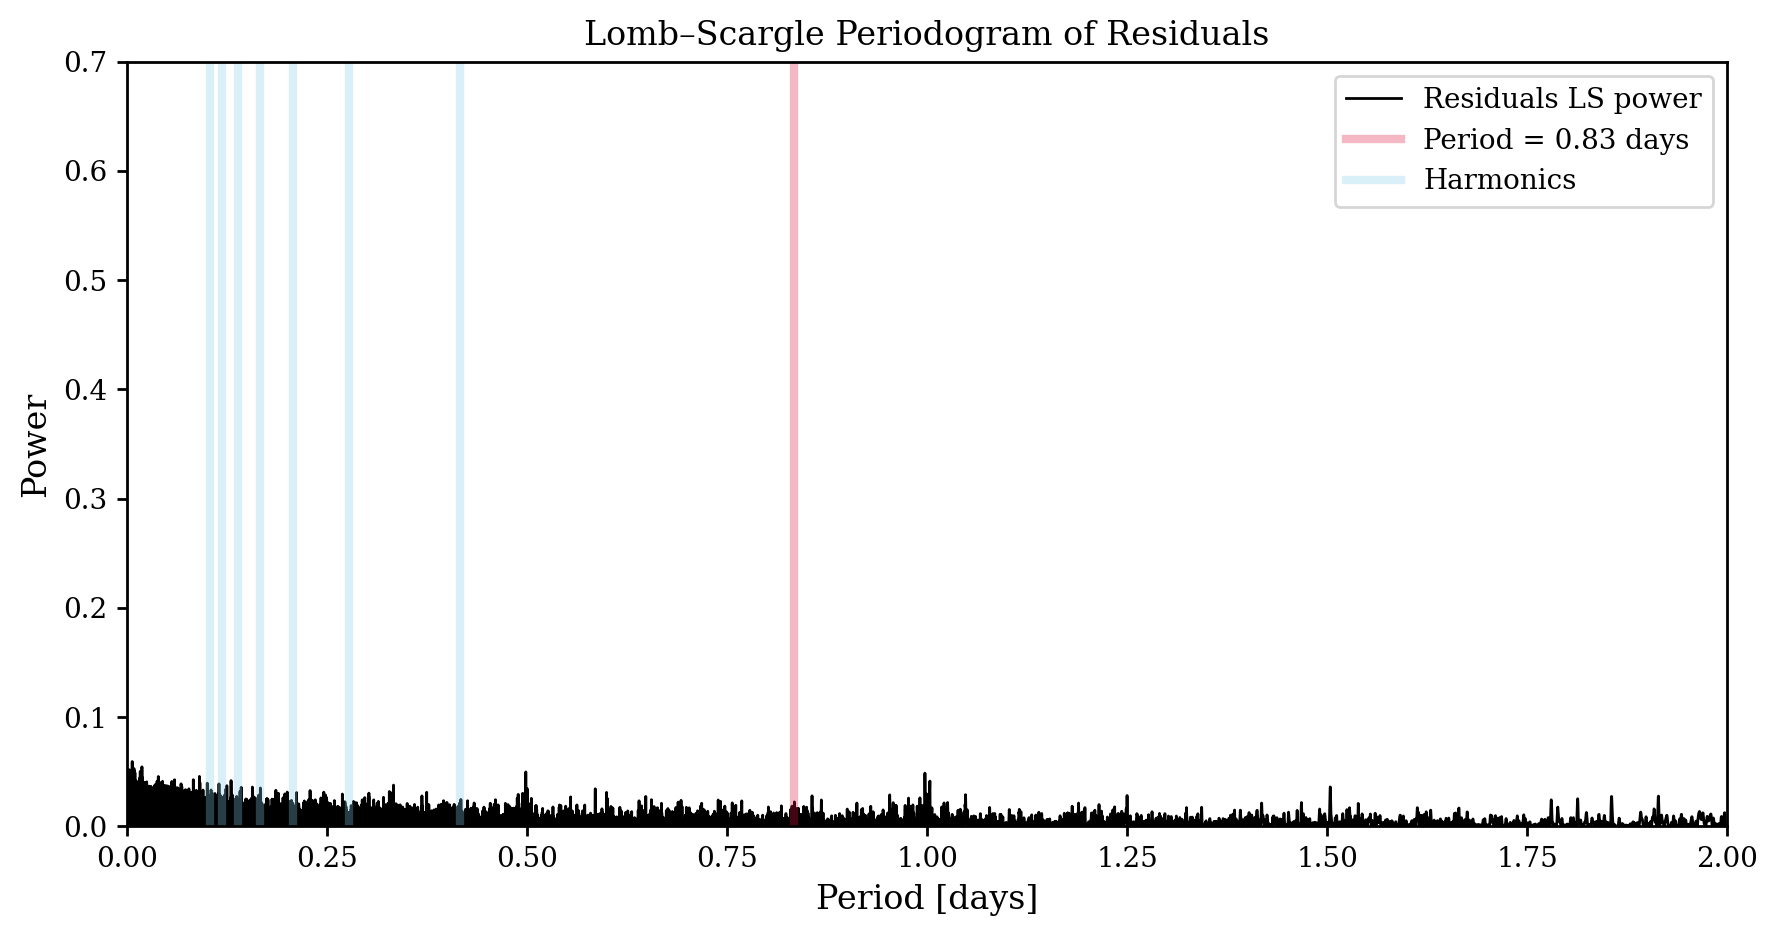

In [26]:
residuals = Y - yfit12

freq_res, power_res = LombScargle(data['time'].data, residuals, data['uncertainty'].data).autopower(nyquist_factor=3000)

period_res = 1.0 / freq_res



# Plotting
plt.figure(figsize=(9, 4.8))
plt.plot(period_res, power_res, color='black', linewidth=1, label='Residuals LS power')

# Mark the fundamental period and a few harmonics for reference
P0 = period
plt.axvline(P0, color='crimson', linewidth=3, alpha=0.3, label=fr'Period = {P0:.2f} days')
for k in range(2, 9):
    lbl = 'Harmonics' if k == 2 else None
    plt.axvline(P0 / k, color='skyblue', linewidth=3, alpha=0.3, label=lbl)


plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title('Lomb–Scargle Periodogram of Residuals')
plt.ylim(0,0.7)
plt.xlim(0, 2)
plt.legend()
plt.tight_layout()

### Written Part
Yes, it seems like we fit out all the important signals.

:::{tip} **Extra Credit 1**

Download the lightcurves of more Cepheids from the OGLE database: [https://ogledb.astrouw.edu.pl/~ogle/OCVS/ceph_query.php](https://ogledb.astrouw.edu.pl/~ogle/OCVS/ceph_query.php) 

Fit penalized regression models to them. (*Hint*: it can be helpful to define a `class` to avoid code duplication.)
:::

In [27]:
## Your extra credit code here: 

#from astropy.io import ascii

#filename = 'data.txt'

#data = ascii.read(filename, format = '',data_start = 7, header_start = 6)
#data

#ascii.read.help() <--------- Why does this not work, if the astropy documentation says it should?

:::{tip} **Extra Credit 2**
Peform exploratory data analysis on the fitted models for your set of Cepheids to find relationships between the period, amplitudes, etc. 
:::

In [28]:
## Your extra credit code here: 



ChatGPT link: 